In [1]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
%matplotlib widget

import os
import tempfile

# torch random seed
torch.manual_seed(0)

# Lorenz analysis
In this notebook we compare the performance of the different model on the lorenz dataset.

## Useful functions

In [2]:
def lorenz(t, Y):
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    t (float): time
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return [dxdt, dydt, dzdt]


def seq_lorenz(Y):
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y[:, 0], Y[:, 1], Y[:, 2]
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return np.array([dxdt, dydt, dzdt]).T

In [7]:
def plot_components(X, Y):
    """
    This function plots the components of the state vector Y as a function of time X.
    """
    plt.figure(figsize=(3.5*3, 3.5*1))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.grid()
    plt.tight_layout()



def plot_compare_components(X, Y, Y_pred, save=False, name=None):
    """
    This function plots the components of the state vector Y and Y_pred as a function of time X.
    """
    plt.figure(figsize=(3.5*3, 3.5*1))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.plot(X, Y_pred[:,0], label='x_pred')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if save:
        #plt.suptitle(name)
        plt.savefig('../plot/' + name + '.pdf')


def show_history(history, name=None):
    """
    This function plots the loss and learning rate as a function of epoch.
    """
    history = np.array(history)
    fig, ax = plt.subplots(figsize=(3.5*3, 3.5*1))

    # plot the loss
    ax.plot(history[:, 0], label='loss')
    ax.legend(loc='upper left')
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.grid()

    # plot the learning rate
    ax2 = ax.twinx()
    ax2.plot(history[:, -1], label='lr', color='r')
    ax2.set_yscale('log')
    ax2.set_ylabel('lr')
    # legend to the right
    ax2.legend(loc='upper right')
    plt.grid()
    #plt.title('history' + name)
    plt.tight_layout()

    # history to list
    history = history.tolist()

    

# def a function called ode_loss
def lorenz_loss_ode(model, X):
    """
    This function calculates the loss of the ode for the Lorenz system
    as a function of the input tensor X (time).
    Parameters:
    model (torch.nn.Module): the model
    X (torch.tensor): the input tensor
    """

    X.requires_grad = True
    Y_pred = model(X)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 20 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = (dx_dt_pred[:,0]- dx_dt_ode)**2 + (dy_dt_pred[:,0]- dy_dt_ode)**2 + (dz_dt_pred[:,0]- dz_dt_ode)**2

    return loss_ode



def plot_propagation(X, Y_true, Y_pred, Y0_index, save=False, name=None):
    """
    This function compare predicted and true solution of the lorenz system,
    in addition there is the solution (with solve_ivp) propagated from the predicted state at the Y0_index.
    Parameters:
    X (array): time
    Y_true (array): true state
    Y_pred (array): predicted state
    Y0_index (int): index of the predicted state to be used as initial condition
    """

    # get the predicted state for the maximum index
    Y0 = Y_pred[Y0_index]

    # evove with the lorenz function, use scipy ivp_solve
    sol = sp.integrate.solve_ivp(lorenz, [X[Y0_index], 1], Y0, t_eval=X[Y0_index:])

    # plot the solution
    plt.figure(figsize=(3.5*3, 3.5*1))
    plt.subplot(131)
    plt.plot(sol.t, sol.y[0], label='x_prop', marker='o')
    # plot the predicted solution
    plt.plot(X, Y_pred[:,0], label='x_pred')
    # plot x real
    plt.plot(X, Y_true[:,0], label='x_real')
    # red dot in the maximum index
    plt.plot(X[Y0_index], Y_pred[Y0_index,0], 'ro')
    plt.ylabel('x')
    plt.xlabel('t')
    plt.grid()
    plt.legend()

    # do all the same for y
    plt.subplot(132)
    plt.plot(sol.t, sol.y[1], label='y_prop', marker='o')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.plot(X, Y_true[:,1], label='y_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,1], 'ro')
    plt.ylabel('y')
    plt.xlabel('t')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(sol.t, sol.y[2], label='z_prop', marker='o')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.plot(X, Y_true[:,2], label='z_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,2], 'ro')
    plt.ylabel('z')
    plt.xlabel('t')
    plt.grid()
    plt.tight_layout()

    if save:
        #plt.suptitle(name)
        plt.savefig('../plot/' + name + '.pdf')

In [8]:

class PINN_LearningSchedule:
    # write documentation
    """
    This class implements the learning schedule for the PINN model.
    """
    
    def __init__(self, experiment_folder, experiment_name, 
                 precision=None, n_points_checkpoint=1, model=None):
        """
        This function initializes the class.
        Checks if the experiment folder exists, if not, creates it.

        Parameters:
        experiment_folder (str): path to the experiment folder
        experiment_name (str): name of the experiment
        precision (float): precision hyperparameter
        n_points_checkpoint (int): number of points to save the model
        model (torch.nn.Module): model to train
        """
        self.experiment_folder = experiment_folder
        self.experiment_name = experiment_name

        self.n_points_checkpoint = n_points_checkpoint
        self.precision = precision

        self.X = None
        self.Y = None

        # if experiment folder does not exist, create it
        if not os.path.exists(experiment_folder):
            os.makedirs(experiment_folder)
            self.experiment_folder = experiment_folder
            self.model = model

            self.n_points = 1
            self.history =[]
            self.epochs = 0

            # print start new experiment
            print('Start new experiment: ', experiment_folder)

        # if experiment folder exists, load the last model
        else:
            self.experiment_folder = experiment_folder

            # get the last model
            list_files = [f for f in os.listdir(experiment_folder) if f.endswith('.pt')]
            number_of_points = [f.split('_')[-1] for f in list_files]
            number_of_points = [f.split('.')[0] for f in number_of_points]
            number_of_points = [int(f) for f in number_of_points]
            max_index = number_of_points.index(max(number_of_points))
            self.n_points = max(number_of_points)

            # load the last model and history
            self.model = torch.load(os.path.join(experiment_folder, list_files[max_index]))
            self.history = np.load(os.path.join(experiment_folder, list_files[max_index].split('.')[0] + '_history.npy'))
            self.epochs = self.history[-1, 0]
            self.history = self.history.tolist()
            # get epochs

            # print load existing experiment, gives the number of points
            print('Load existing experiment: ', experiment_folder, ' with ', self.n_points, ' points', ' and ', self.epochs, ' epochs')

        
    def load_data(self, X, Y):
        """
        This function loads the data to the class.
        """
        self.X = X
        self.Y = Y


    def train(self, max_lr, min_lr, patience=700, factor=0.7):
        """
        This function trains the model using the learning schedule.
        """

        optimizer = torch.optim.Adam(self.model.parameters(), lr=max_lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, min_lr=min_lr)
        loss_fn = torch.nn.MSELoss()  

        while True:
            while True:

                # cut the data to n_points
                X_temp = self.X[:self.n_points]
                Y_temp = self.Y[:self.n_points]

                # convert to torch tensor
                X_temp = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
                Y_temp = torch.tensor(Y_temp, dtype=torch.float32)


                #---------------------------------------------------------------------------------------------------------------------
                # PINN training
                # Train the model using the PINN loss 
                # for one epoch
                #---------------------------------------------------------------------------------------------------------------------
                
                # train the model
                optimizer.zero_grad()
                X_temp.requires_grad = True
                Y_pred = self.model(X_temp)

                # get the derivatives
                dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X_temp, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
                dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X_temp, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
                dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X_temp, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

                # get true derivatives, using the lorenz parameter
                dx_dt_ode = 10 * (Y_pred[:,1] - Y_pred[:,0])
                dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
                dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

                # loss ode
                loss_ode = loss_fn(dx_dt_pred[:,0], dx_dt_ode) + loss_fn(dy_dt_pred[:,0], dy_dt_ode) + loss_fn(dz_dt_pred[:,0], dz_dt_ode)

                # add loss ic
                loss_ic = torch.mean((Y_pred[0] - Y_temp[0])**2)

                loss = 20*loss_ode + loss_ic

                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                #---------------------------------------------------------------------------------------------------------------------
                

                self.epochs += 1

                
                # save history
                if self.epochs % 1000 == 0:
                    self.history.append([self.epochs, loss.item(), loss_ode.detach().numpy(), loss_ic.detach().numpy(), optimizer.param_groups[0]["lr"], self.n_points])
                    print(f'N_points, {self.n_points}, Epoch {self.epochs}, Loss {loss.item()}, lr {optimizer.param_groups[0]["lr"]}')

                # check loss, if less than precision, break and n_points + 1
                if loss < self.precision:
                    break

            # save the model at n_points_checkpoint
            if self.n_points % self.n_points_checkpoint == 0:
                date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
                torch.save(self.model, os.path.join(self.experiment_folder, f'{self.experiment_name}_{date}_{self.n_points}.pt'))
                # print model saved
                print('Model saved at ', os.path.join(self.experiment_folder, f'{self.experiment_name}_{date}_{self.n_points}.pt'))
                # save history
                np.save(os.path.join(self.experiment_folder, f'{self.experiment_name}_{date}_{self.n_points}_history.npy'), self.history)
            
            # if num_pint equal total number of points, break
            if self.n_points == len(self.X):
                # print end of experiment
                print('End of experiment, reached the end of the data')
                break
            
            # increase n_points
            self.n_points = self.n_points + 1

            # restart lr scheduler
            optimizer = torch.optim.Adam(self.model.parameters(), lr=max_lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, min_lr=min_lr)

    def get_history(self):
        return self.history


## Load data

In [9]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/Lorenz_data.npy')
# Y is the state, X is the time, Y is made of x, y, z
X = data[:,0]
Y = data[:,1:]

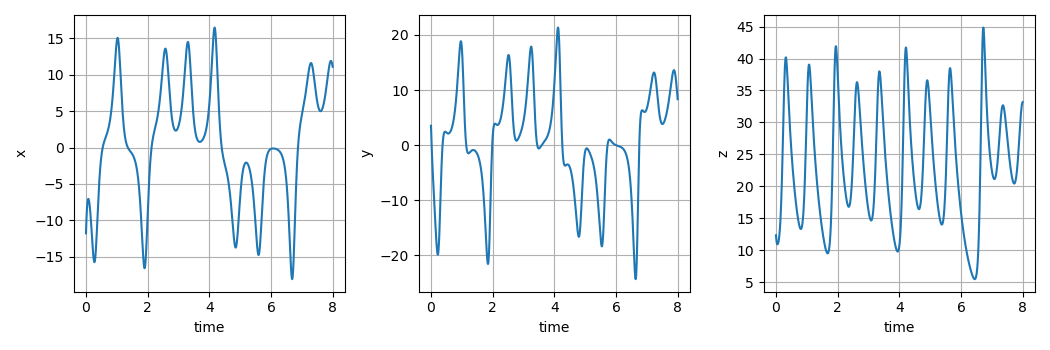

In [10]:
# plot components
plot_components(X, Y)

## Define the model
This is inspired by the tuned model on DHO

In [11]:
# Model class
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 3))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [12]:
n_layers = 4
n_neurons = 28
n_epochs = 10000
# create model
short_model = FFNN(n_layers, n_neurons)

## Short and long model
Here we present the results of the short and long model, we start with the short model.

In [13]:
# select only time < 0.25
X_sub = X[X<0.25]
Y_sub = Y[X<0.25]

# to torch
X_sub_t = torch.tensor(X_sub).float().view(-1, 1)
Y_sub_t = torch.tensor(Y_sub).float()

In [14]:
# load ../model/short_model_lorenz.pt
short_model = torch.load('../models/Lorenz_PINN_baseline/Lorenz_short_baseline.pt')

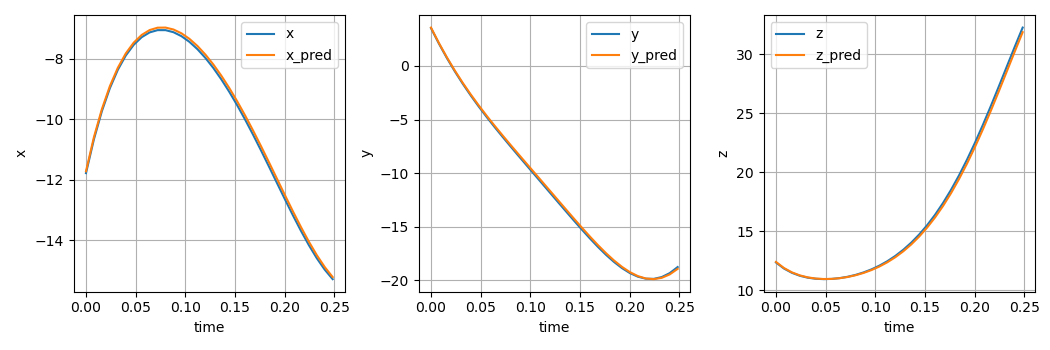

In [15]:
# plot compare
Y_pred = short_model(X_sub_t)
Y_pred = Y_pred.detach().numpy()
plot_compare_components(X_sub, Y_sub, Y_pred, save=True, name='Lorenz_short_model')

In [16]:
# get mse
mse = torch.nn.MSELoss()
loss = mse(short_model(X_sub_t), Y_sub_t)
# print short mse
print('short model mse:', loss.item())

short model mse: 0.025902362540364265


In [17]:
# select only time < 0.25
X_sub = X[X<1]
Y_sub = Y[X<1]

# to torch
X_sub_t = torch.tensor(X_sub).float().view(-1, 1)
Y_sub_t = torch.tensor(Y_sub).float()

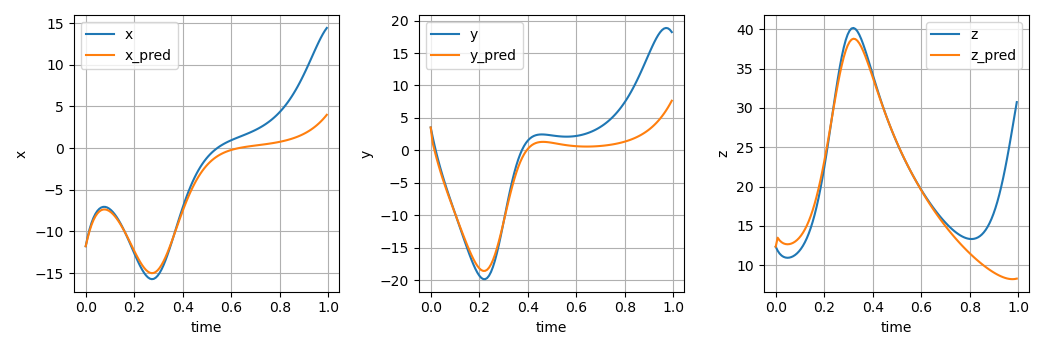

In [18]:
# load ../model/long_model_lorenz.pt
long_model = torch.load('../models/Lorenz_PINN_baseline/Lorenz_long_baseline.pt')
# plot compare
Y_pred = long_model(X_sub_t)
Y_pred = Y_pred.detach().numpy()
plot_compare_components(X_sub, Y_sub, Y_pred, save=True, name='Lorenz_long_model')

In [19]:
# get and print mse
loss = mse(long_model(X_sub_t), Y_sub_t)
print('long model mse:', loss.item())

long model mse: 21.551982879638672


We can see that short model have a mse 3 order of magnitute lower than long model even if the training was performed for 3x epochs. This indicate, together with the plateau of the loss history, that is not because the long model did not converge.

We try to convice ourself looking at the loss_ode in time.

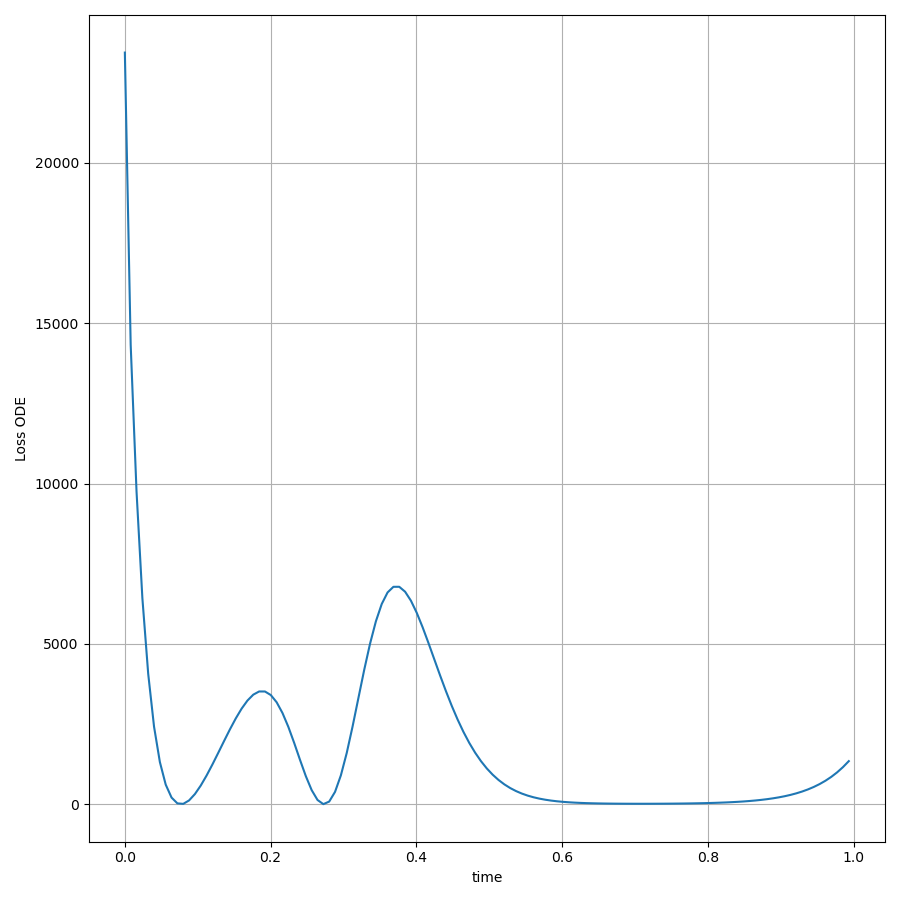

In [23]:
# get loss ode
loss_ode = lorenz_loss_ode(long_model, X_sub_t)
# plot loss ode
plt.figure(figsize=(9, 9))
plt.plot(X_sub, loss_ode.detach().numpy())
plt.ylabel(r'Loss ODE')
plt.xlabel('time')
plt.grid()
#plt.title('Lorenz_long_model, loss ode')
plt.tight_layout()
plt.savefig('../plot/Lorenz_long_model_loss_ode.pdf')

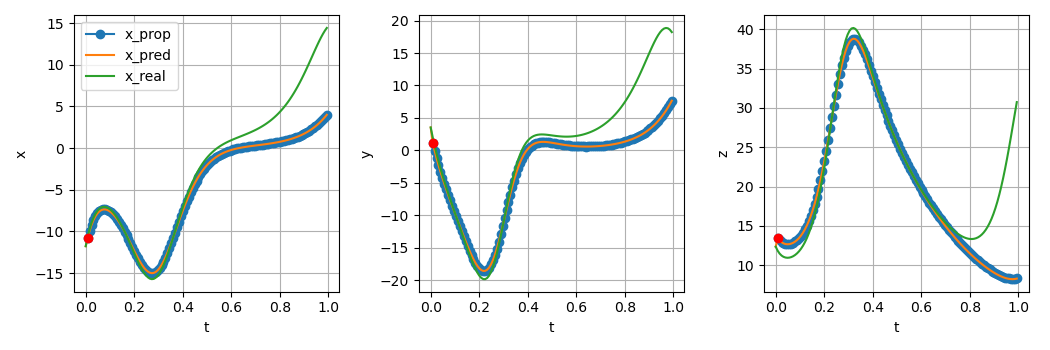

In [24]:
# propagate
plot_propagation(X_sub, Y_sub, Y_pred, 1, save=True, name='Lorenz_long_model, propagation')

In the last plot we show that propagating with RK the state predicted in the points where the error is higer, the numerical solution and the predicted one is very similar. This is a good indication that the model actually converged but on another solution, as the IC are different. This ispired us to produce the Learning Schedule algorithm for training the PINN on chaotic system.

## PINN with learning schedule

In [25]:
# load experiment, folder name ../lorenz_PINN_shortbow

experiment_folder = '../models/lorenz_PINN_shortbow'
experiment_name = 'lorenz'

shortbow_PINN_LS = PINN_LearningSchedule(experiment_folder, experiment_name)

Load existing experiment:  ../models/lorenz_PINN_shortbow  with  120  points  and  26094000.0  epochs


In [26]:
# get number of points
n_points = shortbow_PINN_LS.n_points

In [27]:
# select only time < 0.25
X_sub = X[:n_points]
Y_sub = Y[:n_points]

# to torch
X_sub_t = torch.tensor(X_sub).float().view(-1, 1)
Y_sub_t = torch.tensor(Y_sub).float()

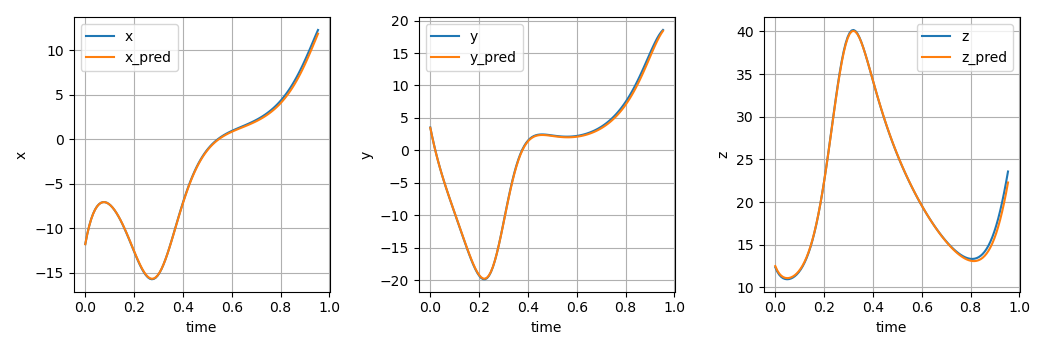

In [28]:
# show compare
Y_pred = shortbow_PINN_LS.model(X_sub_t)
Y_pred = Y_pred.detach().numpy()
plot_compare_components(X_sub, Y_sub, Y_pred, save=True, name='Lore')

In [29]:
# get mse and print
loss = mse(shortbow_PINN_LS.model(X_sub_t), Y_sub_t)
print('shortbow PINN mse:', loss.item())

shortbow PINN mse: 0.06708767265081406


So the LS_model mse is nearly the same of the short one. With this example we demostrate that is possible to train a PINN on chaotic system with a learning schedule for longer time. The drowback of this method is that it take 3 night of training to converge.

## RNN 

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader

class RNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=3, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = torch.nn.Linear(100, 3)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [31]:

# Load the data and create a DataFrame
D = np.load('../data/Lorenz_data_RNN.npy')
df = pd.DataFrame(D)
df.columns = ["time", "x", "y","z"]  

# Extract x, y, and z time series
timeseries_x = df[["x"]].values.astype('float32')
timeseries_y = df[["y"]].values.astype('float32')
timeseries_z = df[["z"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries_x) * 0.5)
test_size = len(timeseries_x) - train_size

# Extract time series for overall data
times = df[["time"]].values.astype('float32')
timeseries =  df[["x", "y","z"]]


# train-test split for x, y, and z time series
x_train, x_test = timeseries_x[:train_size], timeseries_x[train_size:]
y_train, y_test = timeseries_y[:train_size], timeseries_y[train_size:]
z_train, z_test = timeseries_z[:train_size], timeseries_z[train_size:]
t_train, t_test = times[:train_size], times[train_size:]

# Function to create the dataset
def create_dataset(dataset_x, dataset_y, dataset_z, lookback):
    X, y = [], []
    for i in range(len(dataset_x)-lookback):
        # Create feature by stacking lookback points of x, y, and z
        feature = np.column_stack((dataset_x[i:i+lookback], dataset_y[i:i+lookback], dataset_z[i:i+lookback]))
        # Create target by stacking lookback+1 points of x, y, and z
        target = np.column_stack((dataset_x[i+1:i+lookback+1], dataset_y[i+1:i+lookback+1], dataset_z[i+1:i+lookback+1]))  
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 5
X_train, y_train  = create_dataset(x_train, y_train, z_train, lookback=lookback)


/tmp/ipykernel_488645/4087785664.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /croot/pytorch-select_1707782759820/work/torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X), torch.tensor(y)


In [32]:

model = RNNModel()
model.load_state_dict(torch.load('../models/Lorenz_LSTM.pt'))
model.eval()

last_index = np.max(np.where(times < 1))
last_index = last_index 

train_true_x = timeseries_x[:lookback]
train_true_y = timeseries_y[:lookback]
train_true_z = timeseries_z[:lookback]


test_plot_x = np.ones_like(timeseries_x) * np.nan
test_plot_y = np.ones_like(timeseries_y) * np.nan
test_plot_z = np.ones_like(timeseries_z) * np.nan

test_true_x = timeseries_x[lookback:]
test_true_y = timeseries_y[lookback:]
test_true_z = timeseries_z[lookback:]
test_t = times[lookback:]

with torch.no_grad():
    input_seq_x = torch.from_numpy(train_true_x)
    input_seq_y = torch.from_numpy(train_true_y)
    input_seq_z = torch.from_numpy(train_true_z)
    input_seq = torch.stack([input_seq_x, input_seq_y, input_seq_z], dim=1)
    input_seq = input_seq.view(1, lookback, 3)
    x_test, y_test, z_test = [], [], [] 
    for i in range(len(timeseries_x)-lookback):
        predicted = model(input_seq)
        x_test.append(predicted[0, -1, 0].item())
        y_test.append(predicted[0, -1, 1].item())
        z_test.append(predicted[0, -1, 2].item())
        new_line = predicted[:, -1, :].unsqueeze(0)
        input_seq = torch.cat([input_seq, new_line], dim=1)
        input_seq = input_seq[:, 1:, :]

    test_last_x = np.array(x_test)
    test_last_y = np.array(y_test)
    test_last_z = np.array(z_test)

    test_plot_x[lookback:] = test_last_x.reshape(-1, 1)
    test_plot_y[lookback:] = test_last_y.reshape(-1, 1)
    test_plot_z[lookback:] = test_last_z.reshape(-1, 1)
    test_plot_t = times[:]

    print(test_plot_x.shape)
    print(test_plot_t.shape)


(125, 1)
(125, 1)


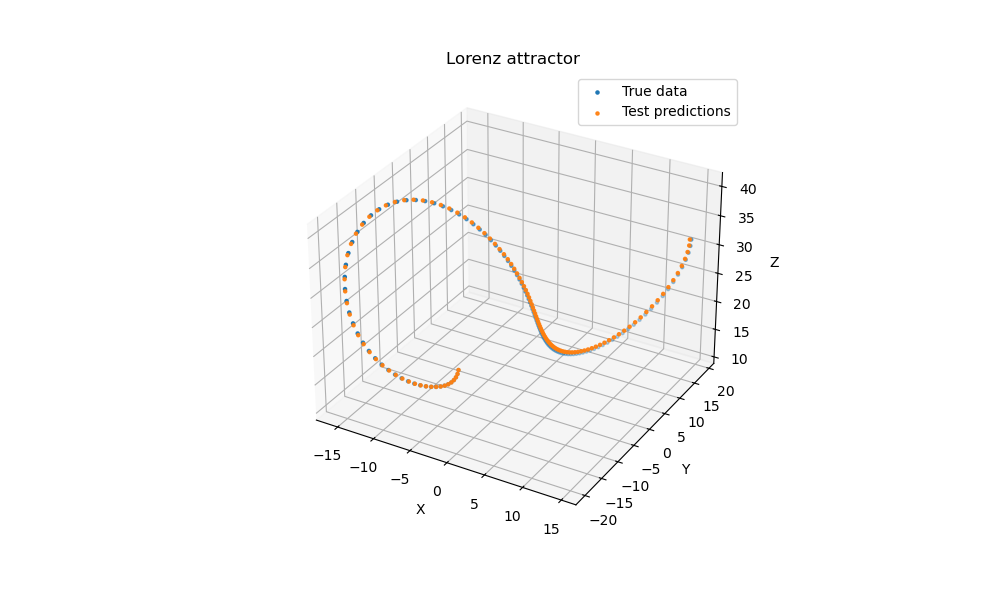

In [33]:

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the training data
ax.scatter(test_true_x,test_true_y,test_true_z,marker='.',label = 'True data')
#ax.scatter(train_plot_x, train_plot_y, train_plot_z,marker = '.',  label='Train Data',alpha = 0.4)

# Plot the testing data
ax.scatter(test_plot_x, test_plot_y, test_plot_z,marker = '.',  label='Test predictions',alpha=0.9)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz attractor')

# Add a legend
ax.legend()

#plt.savefig('../plot/Lorenz_RNN_analysis.pdf')
# Show the plot
plt.show()


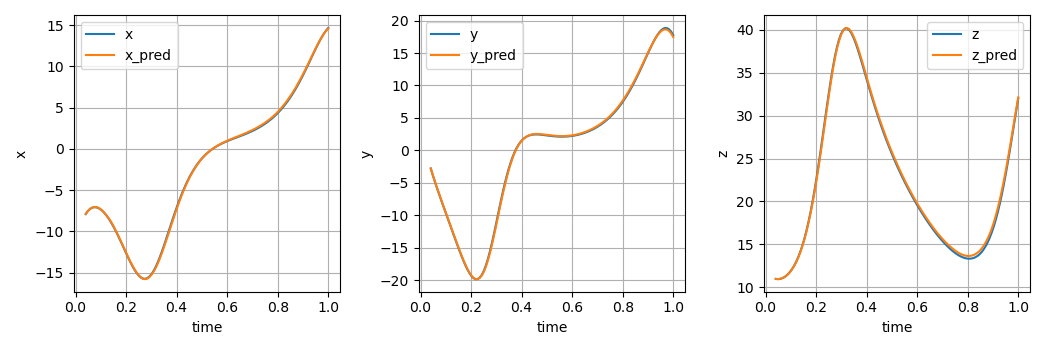

In [35]:
# propagate

plt.figure(figsize=(3.5*3, 3.5))
#plt.suptitle('Lorenz RNN predictions')
plt.subplot(131)
plt.plot(test_t, test_true_x, label='x')
plt.plot(test_plot_t, test_plot_x, label='x_pred')
plt.ylabel('x')
plt.xlabel('time')
plt.legend()
plt.grid()

# do all the same for y
plt.subplot(132)
plt.plot(test_t, test_true_y, label='y')
plt.plot(test_plot_t, test_plot_y, label='y_pred')
plt.ylabel('y')
plt.xlabel('time')
plt.legend()
plt.grid()

# do all the same for z
plt.subplot(133)
plt.plot(test_t, test_true_z, label='z')
plt.plot(test_plot_t, test_plot_z, label='z_pred')
plt.ylabel('z')
plt.xlabel('time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('../plot/Lorenz_RNN_short.pdf')



In [36]:
from sklearn.metrics import mean_squared_error

# Remove nan values from the arrays
clean_test_true_x = test_true_x[~np.isnan(test_true_x)]
clean_test_true_y = test_true_y[~np.isnan(test_true_y)]
clean_test_true_z = test_true_z[~np.isnan(test_true_z)]
clean_test_pred_x = test_plot_x[~np.isnan(test_plot_x)]
clean_test_pred_y = test_plot_y[~np.isnan(test_plot_y)]
clean_test_pred_z = test_plot_z[~np.isnan(test_plot_z)]

# Calculate RMSE for x, y, z coordinates
mse_x = mean_squared_error(clean_test_true_x, clean_test_pred_x)
mse_y = mean_squared_error(clean_test_true_y, clean_test_pred_y)
mse_z = mean_squared_error(clean_test_true_z, clean_test_pred_z)

loss_RNN = mse_x + mse_y + mse_z

print("mse: ",loss_RNN)


mse:  0.09675184
